In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import LabelEncoder

## Analysis of original data

In [10]:
# Load dataset
train_dir = "train.csv"

# Read the data
train_data = pd.read_csv(train_dir)

/var/folders/z0/316nphkd3xsdhxgzmqc9njh00000gn/T/ipykernel_2412/3156795648.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(train_dir)


In [23]:
# Basic Info
print("Basic Dataset Info:")
print(train_data.info())

Basic Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  object 
 1   Hospital_code                      318438 non-null  object 
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  object 
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient  

In [12]:
# Print missing values
print("\nMissing Values:")
print(train_data.isnull().sum())


Missing Values:
case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64


In [13]:
# Summary Statistics
print("\nSummary Statistics:")
print(train_data.describe())


Summary Statistics:
       Hospital_code  City_Code_Hospital  Available Extra Rooms in Hospital  \
count  318438.000000       318438.000000                      318438.000000   
mean       18.318841            4.771717                           3.197627   
std         8.633755            3.102535                           1.168171   
min         1.000000            1.000000                           0.000000   
25%        11.000000            2.000000                           2.000000   
50%        19.000000            5.000000                           3.000000   
75%        26.000000            7.000000                           4.000000   
max        32.000000           13.000000                          24.000000   

           Bed Grade      patientid  City_Code_Patient  Visitors with Patient  \
count  318325.000000  318438.000000      313906.000000          318438.000000   
mean        2.625807   65747.579472           7.251859               3.284099   
std         0.873146   3

## Simple data cleaning (conversions and droppings)

In [24]:
# Drop case_id and patientid
# These are not relevant to our goal
train_data.drop(columns=[col for col in ['case_id', 'patientid'] if col in train_data.columns], inplace=True)

In [22]:
# Convert code numbers to string objects
categorical_codes = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Department', 'Ward_Facility_Code', 'Hospital_region_code', 'Ward_Type', 'City_Code_Patient']
for col in categorical_codes:
    if col in train_data.columns:
        train_data[col] = train_data[col].astype(str)

In [26]:
# Categorize Stay column
stay_mapping = {
    '0-10': 0, '11-20': 1, '21-30': 2, '31-40': 3, '41-50': 4,
    '51-60': 5, '61-70': 6, '71-80': 7, '81-90': 8, '91-100': 9,
    '100 Days': 9, 'More than 100 Days': 10
}
train_data['Stay'] = train_data['Stay'].map(stay_mapping)

In [27]:
# Categorize Age column
age_mapping = {
    '0-10': 0, '11-20': 1, '21-30': 2, '31-40': 3, '41-50': 4,
    '51-60': 5, '61-70': 6, '71-80': 7, '81-90': 8, '91-100': 9,
}
train_data['Age'] = train_data['Age'].map(stay_mapping)

In [28]:
# Basic Info
print("Basic Dataset Info:")
print(train_data.info())

Basic Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 16 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Hospital_code                      318438 non-null  object 
 1   Hospital_type_code                 318438 non-null  object 
 2   City_Code_Hospital                 318438 non-null  object 
 3   Hospital_region_code               318438 non-null  object 
 4   Available Extra Rooms in Hospital  318438 non-null  int64  
 5   Department                         318438 non-null  object 
 6   Ward_Type                          318438 non-null  object 
 7   Ward_Facility_Code                 318438 non-null  object 
 8   Bed Grade                          318325 non-null  float64
 9   City_Code_Patient                  318438 non-null  object 
 10  Type of Admission                  318438 non-null  object 
 11  Severity of Illness

## Analysis of Cleaned data

In [14]:
# Basic Info
print("Basic Dataset Info:")
print(train_data.info())

Basic Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  object 
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient  

In [15]:
train_data.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


Understanding the distribution is essential for us to realize the data is heavily imbalanced, and we must consider this carefully. Interestingly, admission deposit has a positive skew bell curve, and age and bed grade have bell curve-like distributions as well. While most patients face 0-6 extra available rooms or 0-12 vistors in the hospital, there are a few outliers going up to 24 extra rooms or 32 visitors, respectively. None of the columns have even distributions.

## EDA Against Stay: All Numerical Values

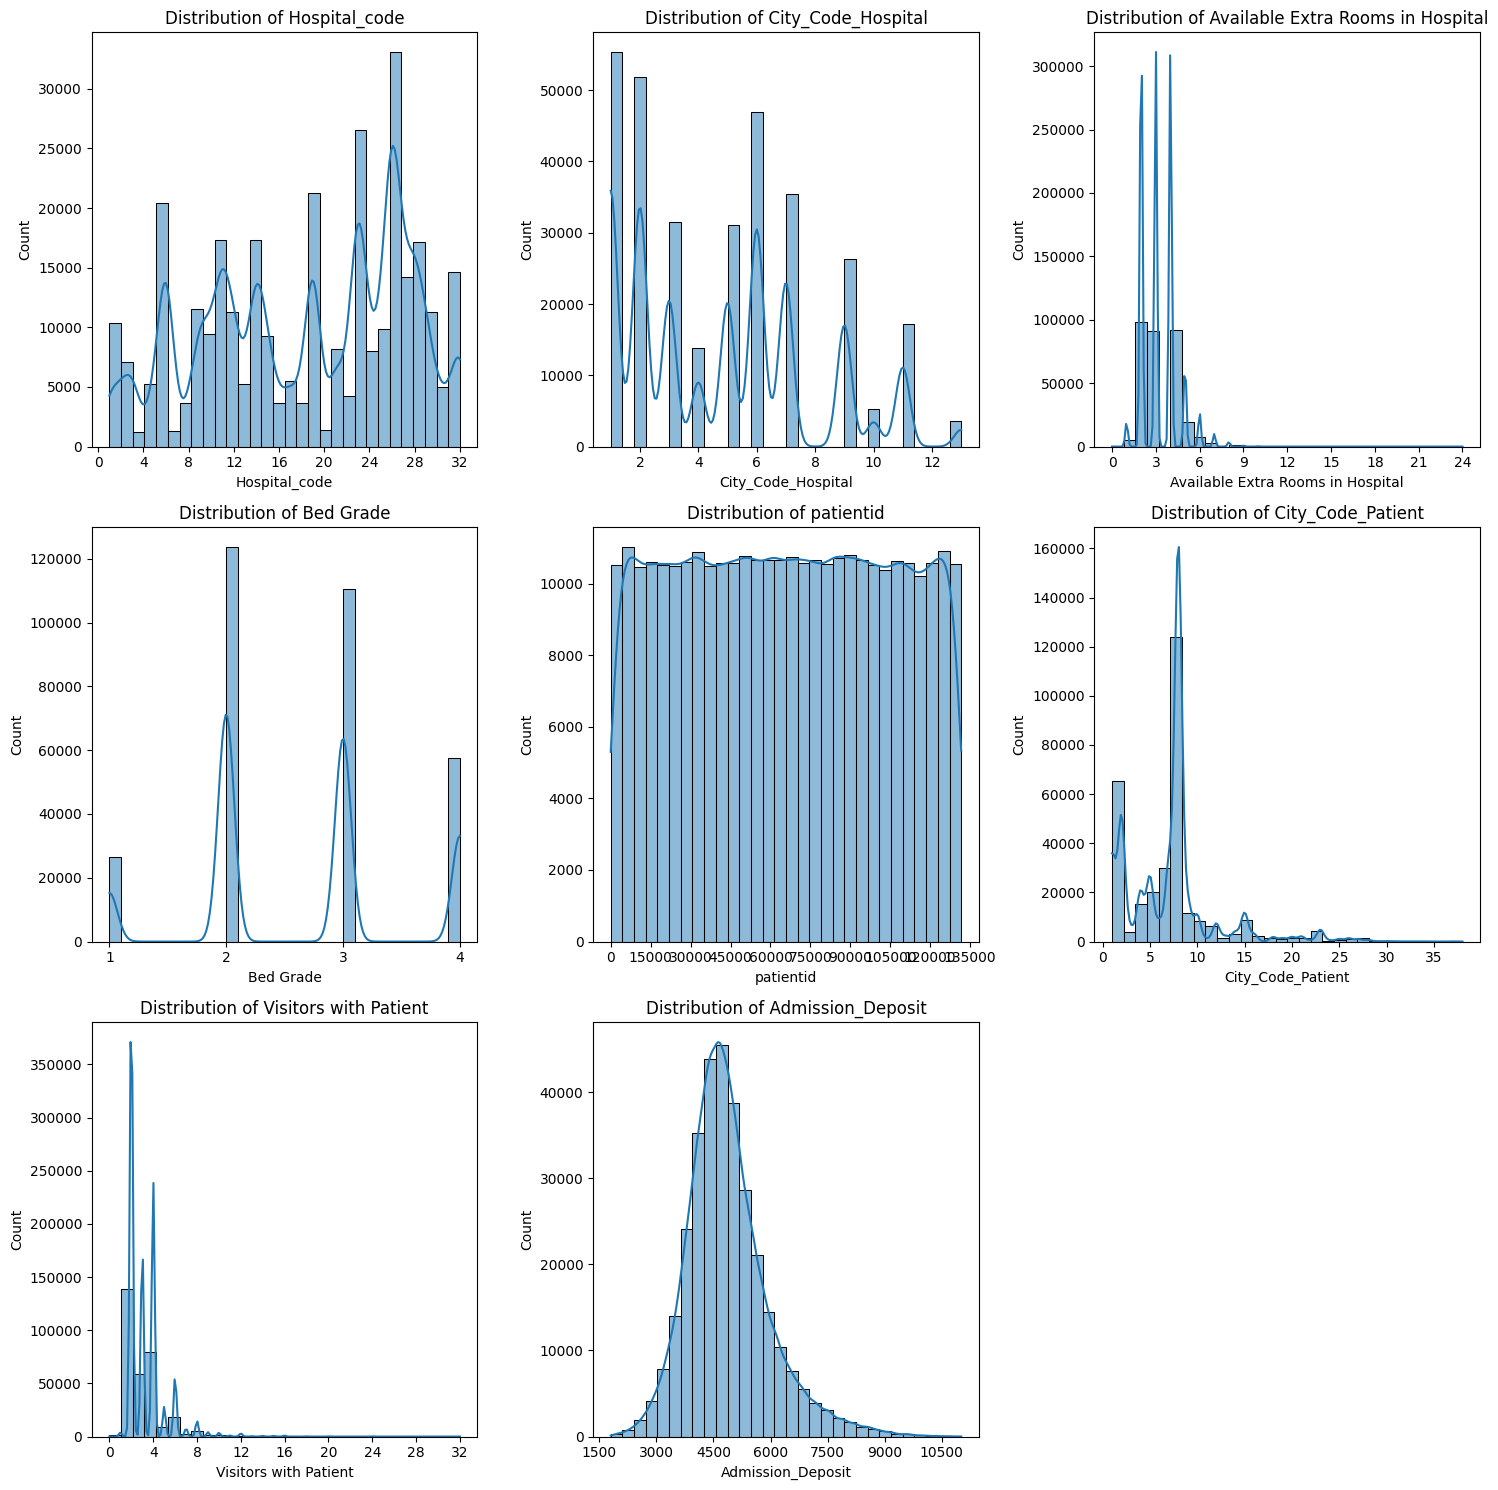

In [16]:
# Select numerical columns
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_features = len(num_cols)
rows = math.ceil(num_features / 3)

# Set figure size
plt.figure(figsize=(15, 5 * rows))

# Loop through numerical columns and plot distributions
for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, 3, i)
    sns.histplot(train_data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    
    # Set integer x-axis ticks only (remove decimals)
    plt.xticks(np.arange(train_data[col].min(), train_data[col].max() + 1, step=max(1, (train_data[col].max() - train_data[col].min()) // 10)), fontsize=10)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure integer ticks

plt.tight_layout()
plt.show()

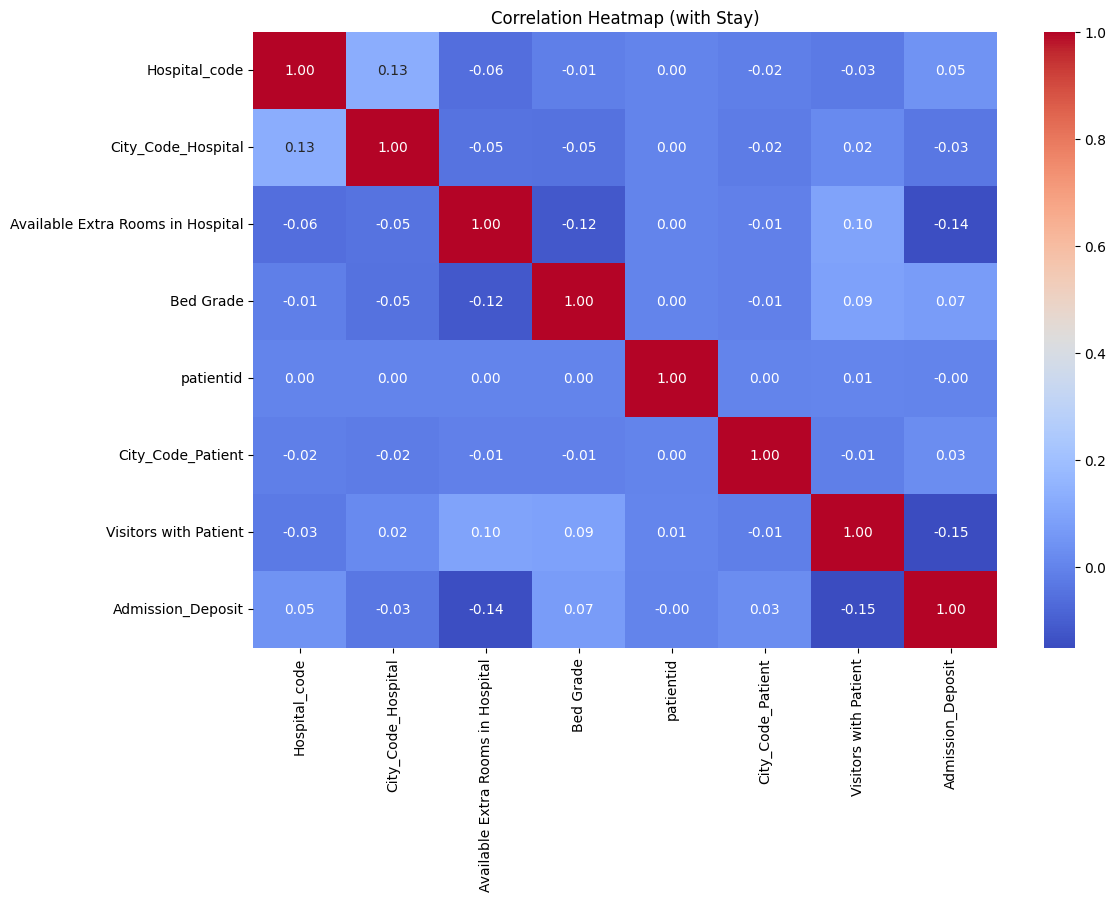

In [17]:
# Compute correlation matrix including Stay
numeric_train_data = train_data.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12, 8))
corr_matrix = numeric_train_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (with Stay)')
plt.show()

We can see that Visitors have the highest correlation against Stay with 0.54, suggesting influence. However, the other values have little correlation.

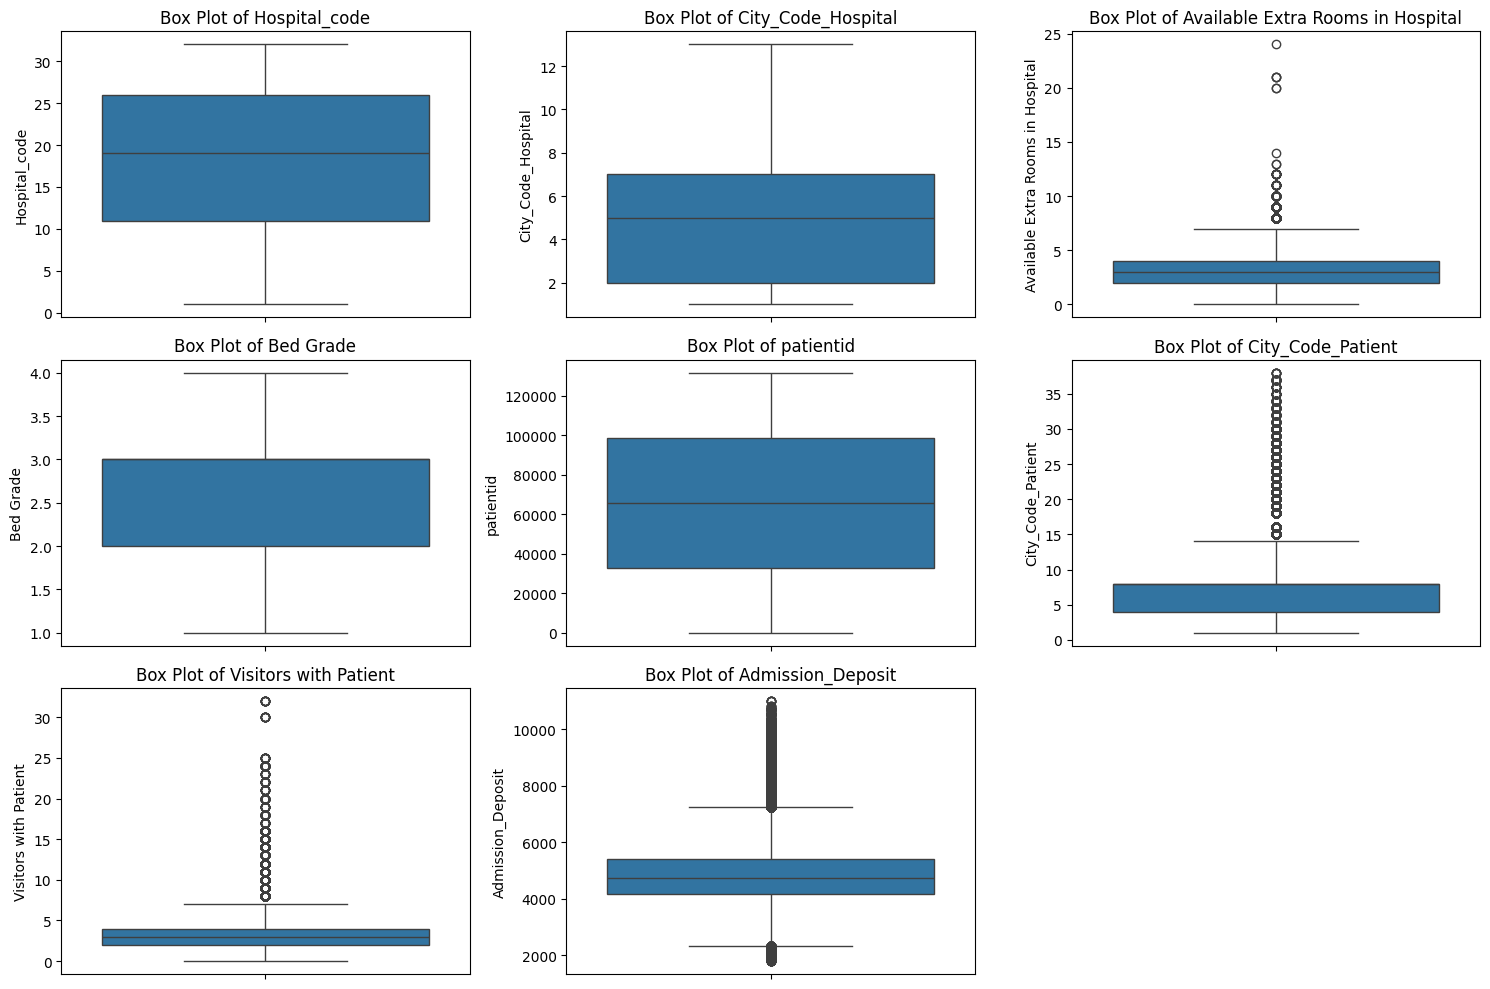

In [18]:
# Box Plots for Outlier Detection
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=train_data[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

Extra Rooms, Visitors, Admission Deposit, and Stay have outliers as they are concentrated in low amounts, but have a few high outliers. Bed Grade and Admission Type are more balanced. The stretchness of severity shows diversity. Age is well spread except for a single outlier

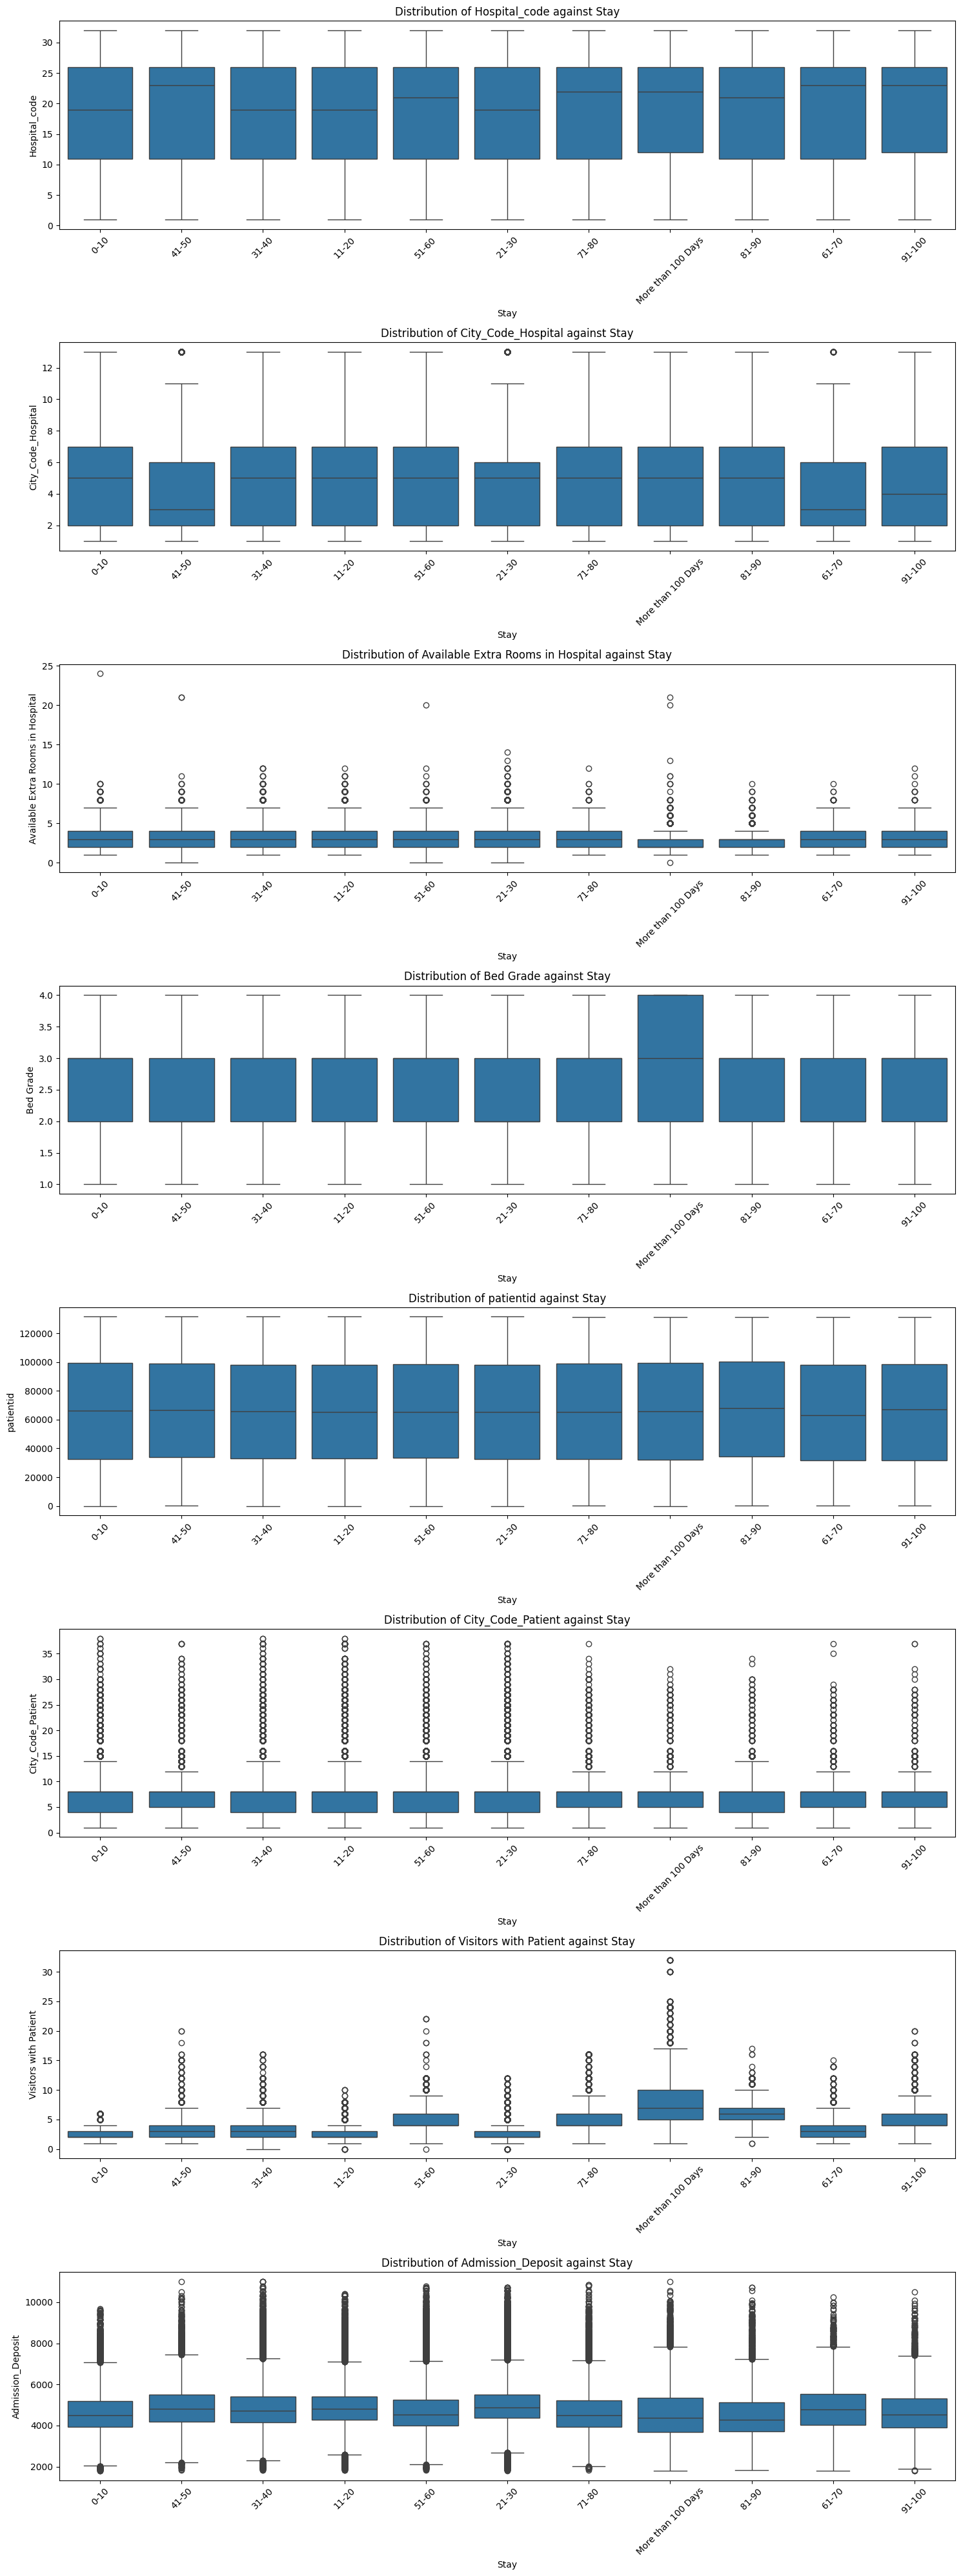

In [19]:
# Get numerical columns but exclude 'Stay'
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = [col for col in num_cols if col != 'Stay']  # Exclude Stay

# Plot box plots for each numerical column against 'Stay'
plt.figure(figsize=(15, 5 * len(num_cols)))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    sns.boxplot(x=train_data['Stay'], y=train_data[col])
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col} against Stay')

plt.tight_layout()
plt.show()

The distribution of Available Extra Rooms remains stable across different Stay lengths, suggesting that the number of available rooms does not significantly impact the length of hospitalization.

While Bed Grade and Type of Admission mostly show moderate distributions, there is some variability. Notably, patients with the longest stays tend to have higher Bed Grades, potentially indicating that patients who stay longer require higher-quality beds. Additionally, Emergency and Urgent admissions are more common for shorter stays compared to Trauma admissions, suggesting that trauma patients may have the shortest hospitalization periods.

The relationship between Severity of Illness and Stay is not entirely consistent, but a trend emerges:: ,inor cases tend to have shorter stays, extreme cases are more common in longer hospital stays, moderate severity cases do not show a clear trend, possibly indicating a more variable recovery period.

The Number of Visitors generally increases with longer hospital stays, though some fluctuations in the trend are present. The median Age remains fairly constant at 4 across different Stay lengths, except for an increase to 5 in the longest stays. This suggests little correlation between Age and Stay, despite a slight increase in the upper quartile (Q4). However, Age = 4 decades has the most values, making it understandable why it may appear the highest throughout.

Finally, Admission Deposit does not show a clear linear relationship with Stay, displaying a fluctuating pattern instead, indicating no strong correlation.

Furthermore, Available Rooms, Visitors, and Admission Deposit tend to have many high outliers, skewing the data.

/var/folders/z0/316nphkd3xsdhxgzmqc9njh00000gn/T/ipykernel_2412/614400776.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[col], label=f'Stay {stay_val}', shade=True)
/var/folders/z0/316nphkd3xsdhxgzmqc9njh00000gn/T/ipykernel_2412/614400776.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[col], label=f'Stay {stay_val}', shade=True)
/var/folders/z0/316nphkd3xsdhxgzmqc9njh00000gn/T/ipykernel_2412/614400776.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(subset[col], label=f'Stay {stay_val}', shade=True)
/var/folders/z0/316nphkd3xsdhxgzmqc9njh00000gn/T/ipykernel_2412/614400776.py:7: FutureWarning: 



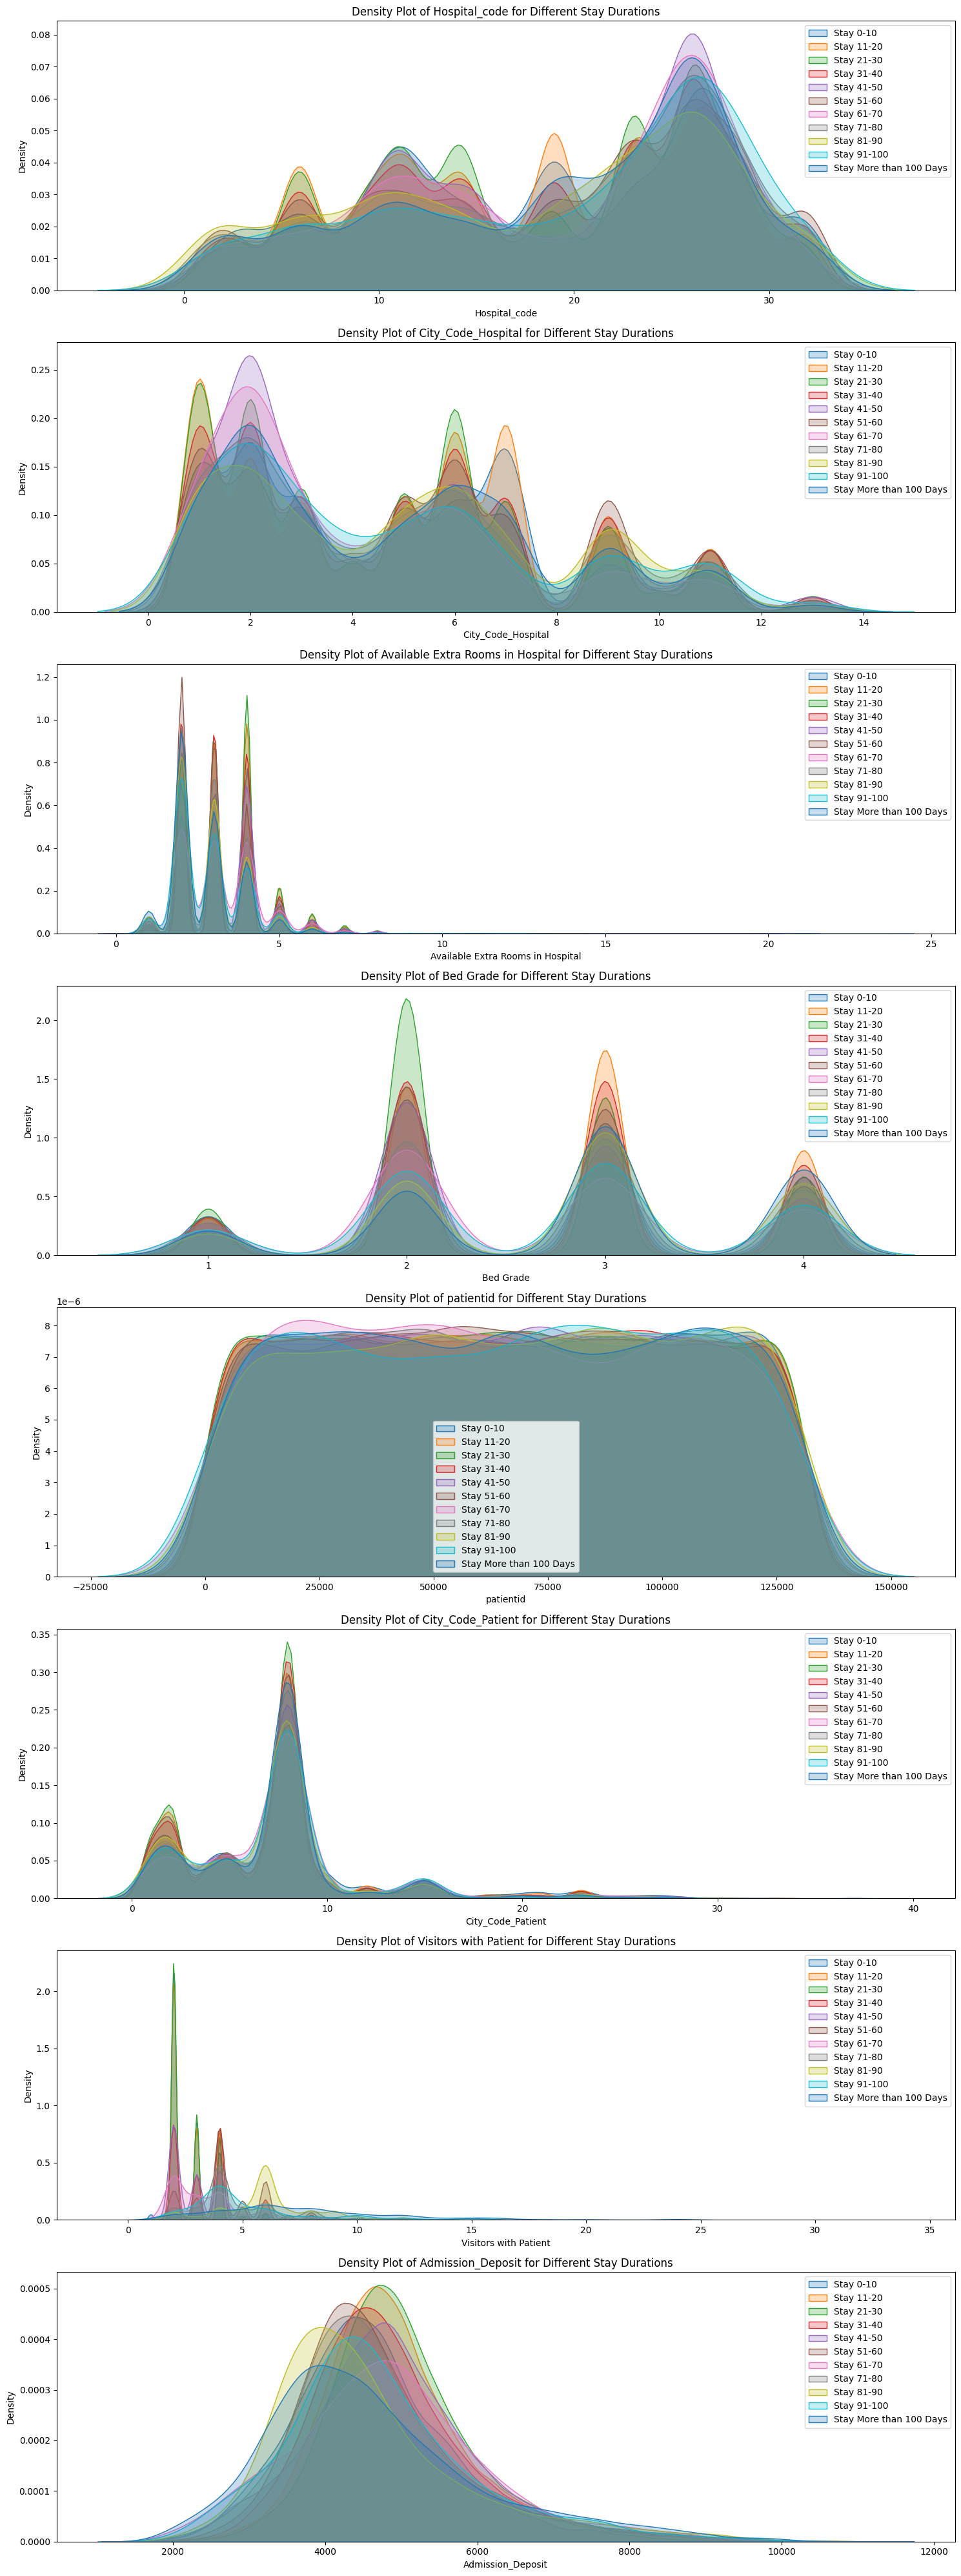

In [20]:
# KDE plots to visualize density distribution of numerical features by Stay
plt.figure(figsize=(15, 5 * len(num_cols)))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    for stay_val in sorted(train_data['Stay'].unique()):
        subset = train_data[train_data['Stay'] == stay_val]
        sns.kdeplot(subset[col], label=f'Stay {stay_val}', shade=True)
    plt.legend()
    plt.title(f'Density Plot of {col} for Different Stay Durations')
plt.tight_layout()
plt.show()

IDK if we should keep these because some data is very skewed, making it hard to draw conclusions

In [21]:
import scipy.stats as stats

# Initialize results dictionary for numerical analysis
stat_results = {}


# Select numerical columns (int64, float64) for statistical analysis
num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Perform statistical tests for each numerical column against Stay
for col in num_cols:
    # Check normality using Shapiro-Wilk test (only works for smaller samples)
    shapiro_stat, shapiro_p = stats.shapiro(train_data[col].dropna())

    # Check correlation using Spearman (non-parametric) and Pearson (parametric) tests
    spearman_corr, spearman_p = stats.spearmanr(train_data[col].dropna(), train_data['Stay'].dropna())
    pearson_corr, pearson_p = stats.pearsonr(train_data[col].dropna(), train_data['Stay'].dropna())

    # Store results
    stat_results[col] = {
        "Shapiro-Wilk P-Value": shapiro_p,  # Normality test
        "Spearman Correlation": spearman_corr,  # Non-parametric correlation
        "Spearman P-Value": spearman_p,
        "Pearson Correlation": pearson_corr,  # Parametric correlation
        "Pearson P-Value": pearson_p
    }

# Convert results to DataFrame
stat_results_df = pd.DataFrame(stat_results).T.sort_values(by="Spearman Correlation", ascending=False)

# Display results
print("\nStatistical Analysis for Numerical Variables:")
print(stat_results_df)

/Users/kashaina/Documents/Classes/CSC4260_DS/myenv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 318438.
  res = hypotest_fun_out(*samples, **kwds)


ValueError: data type <class 'numpy.object_'> not inexact

Visitors with Patient is the strongest predictor of Stay.
Severity of Illness has a weak positive correlation.
Admission Deposit, Extra Rooms, and Type of Admission have weak negative correlations (~-0.10).
Bed Grade has no impact on Stay

## EDA Against Stay: All Categorical Values

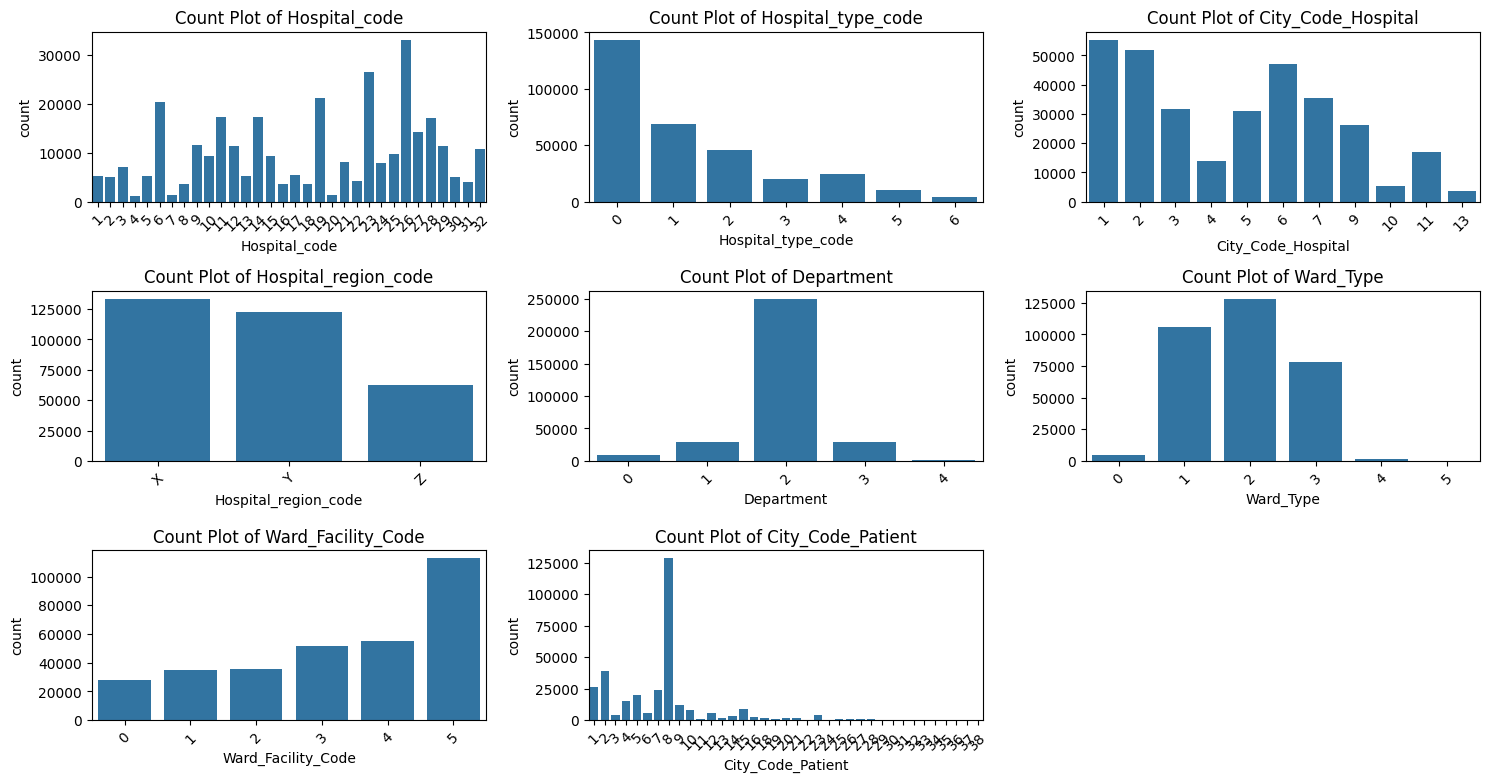

In [ ]:
# Select categorical columns
cat_cols = train_data.select_dtypes(include=['object']).columns.tolist()

# Set figure size dynamically
plt.figure(figsize=(15, 10))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(4, 3, i)

    # Check if the categories are numeric-like and sort numerically
    unique_vals = train_data[col].dropna().unique()
    
    try:
        sorted_order = sorted(unique_vals, key=lambda x: float(x))  # Sort numerically
    except ValueError:
        sorted_order = sorted(unique_vals)  # Default alphabetical order if not numeric

    sns.countplot(x=train_data[col], order=sorted_order)
    plt.xticks(rotation=45)
    plt.title(f'Count Plot of {col}')

plt.tight_layout()
plt.show()

The count plots display the distribution of various categorical hospital-related variables. Hospital codes are widely dispersed. Hospital type codes show that type 0 is the most common, while other types have significantly lower counts. City codes for hospitals and patients exhibit a skewed distribution, where a few codes dominate the dataset. Hospital region codes indicate that regions 0 and 1 have the highest patient distribution, while region 2 is less frequent. Departments are heavily imbalanced, with one department (coded as 2 which is Gynecology) accounting for the majority of patients. Ward types are unevenly distributed, with types 1, 2, and 3 being the most common. Ward facility codes increase in frequency as the code number rises, with facility 5 being the most prevalent. These trends suggest significant disparities in hospital, ward, and department utilization, which may impact patient distribution and hospital workload.

Some codes do not feature some numbesr: City Code Patient does not have 17, and City Code Hospital does not have 8 nor 12.

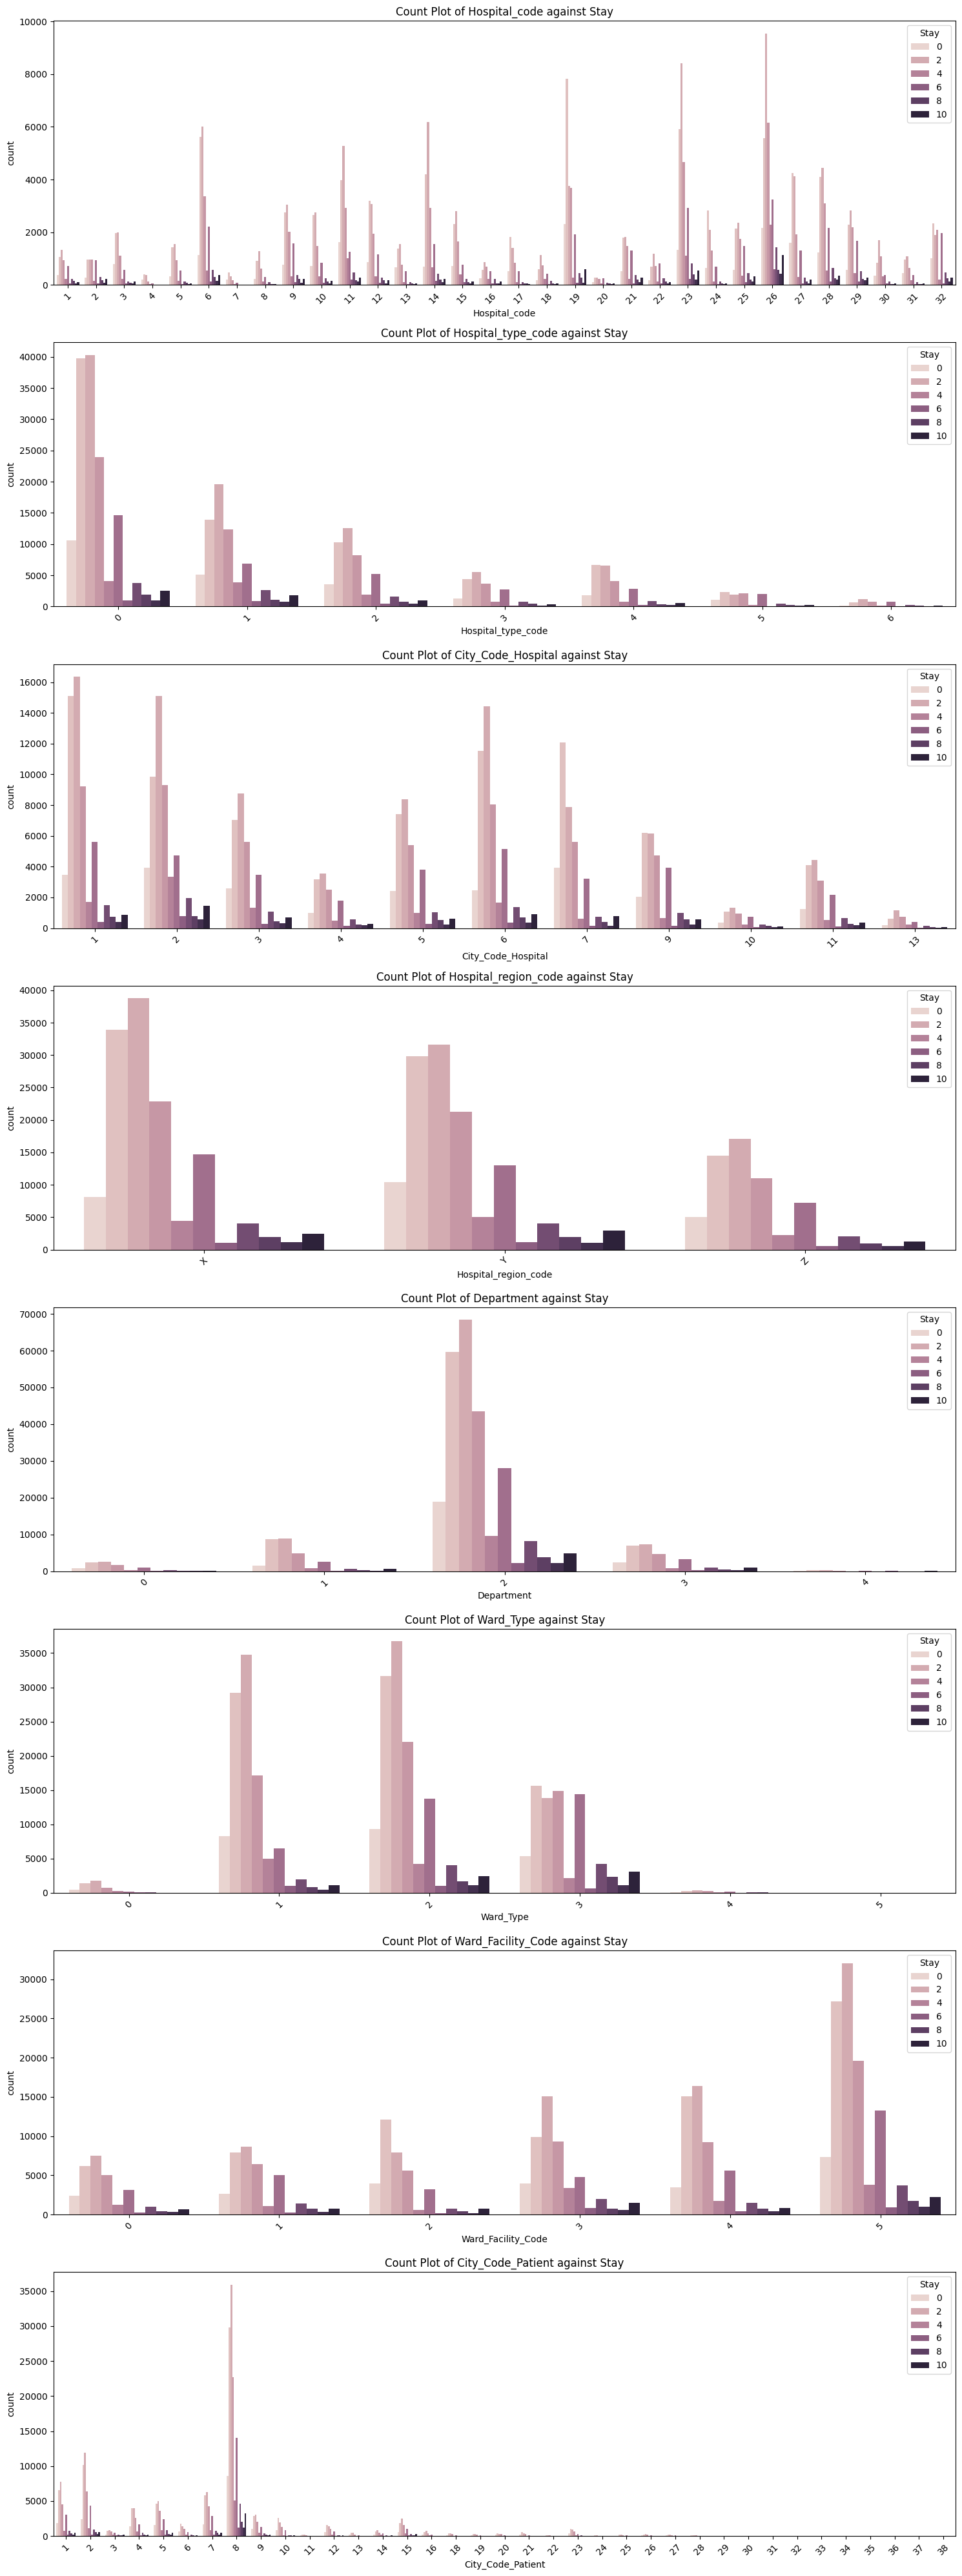

In [ ]:
# Select categorical columns
cat_cols = train_data.select_dtypes(include=['object']).columns.tolist()

# Set figure size dynamically based on the number of categories
plt.figure(figsize=(15, 5 * len(cat_cols)))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(len(cat_cols), 1, i)

    # Extract unique values and attempt to sort them numerically
    unique_vals = train_data[col].dropna().unique()
    
    try:
        sorted_order = sorted(unique_vals, key=lambda x: float(x))  # Numeric sorting
    except ValueError:
        sorted_order = sorted(unique_vals)  # Default to alphabetical if non-numeric

    sns.countplot(x=train_data[col], hue=train_data['Stay'], order=sorted_order)
    plt.xticks(rotation=45)
    plt.title(f'Count Plot of {col} against Stay')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_categorical_proportion(train_data, category_col):
    """
    Creates a stacked bar plot showing the proportion of each category within 'Stay'.
    
    Parameters:
    - train_data: Pandas DataFrame containing the data.
    - category_col: Categorical column to be plotted against 'Stay'.
    """
    if category_col not in train_data.columns:
        print(f"Column '{category_col}' not found in dataset.")
        return
    
    # Compute proportions (normalize=True gives percentages)
    category_counts = train_data.groupby("Stay")[category_col].value_counts(normalize=True).unstack() * 100

    # Sort the column values numerically if possible
    try:
        sorted_order = sorted(category_counts.columns, key=lambda x: float(x))
        category_counts = category_counts[sorted_order]
    except ValueError:
        pass  # If non-numeric, default sorting applies

    # Plot stacked bar chart
    plt.figure(figsize=(10, 6))
    category_counts.plot(kind='bar', stacked=True, color=sns.color_palette("pastel"), figsize=(10, 6))
    
    # Formatting
    plt.title(f"Percentage Distribution of {category_col} by Stay")
    plt.xlabel("Stay Duration")
    plt.ylabel("Percentage of Total Stay")
    plt.legend(title=category_col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    
    # Show plot
    plt.show()

<Figure size 1000x600 with 0 Axes>

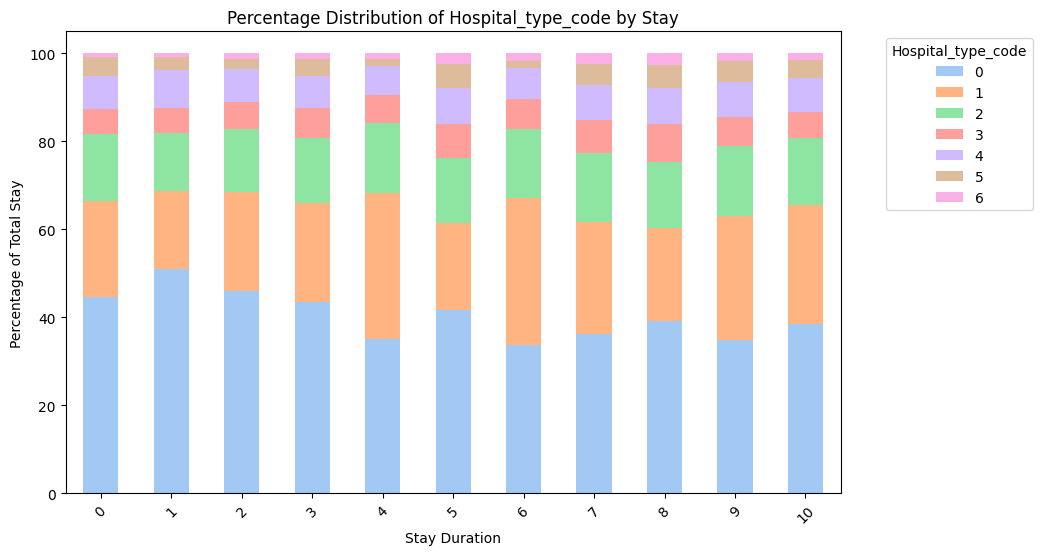

<Figure size 1000x600 with 0 Axes>

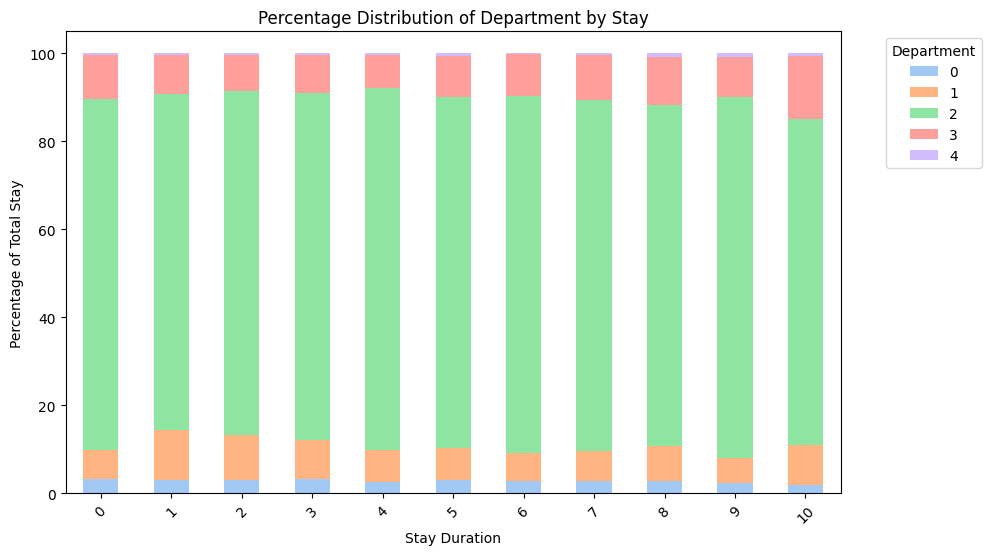

<Figure size 1000x600 with 0 Axes>

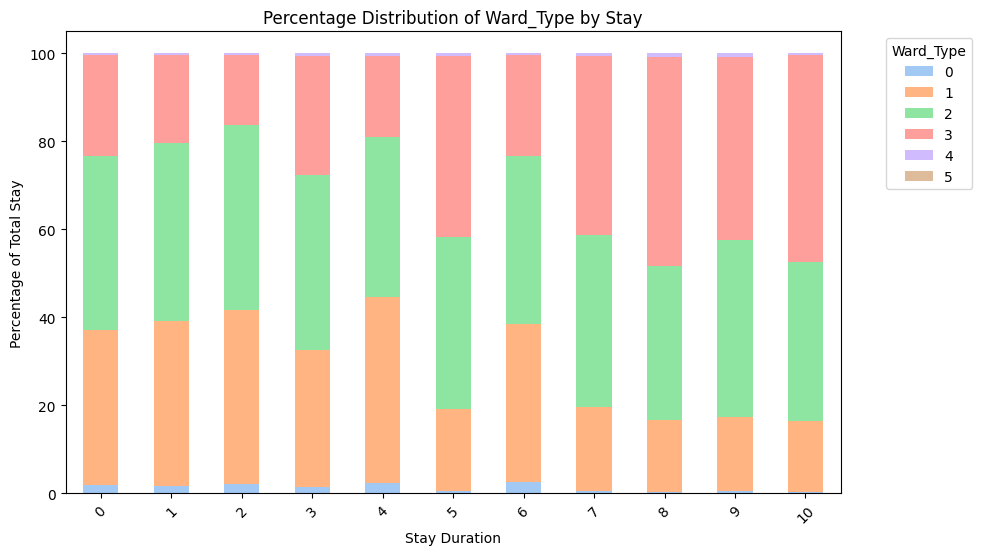

<Figure size 1000x600 with 0 Axes>

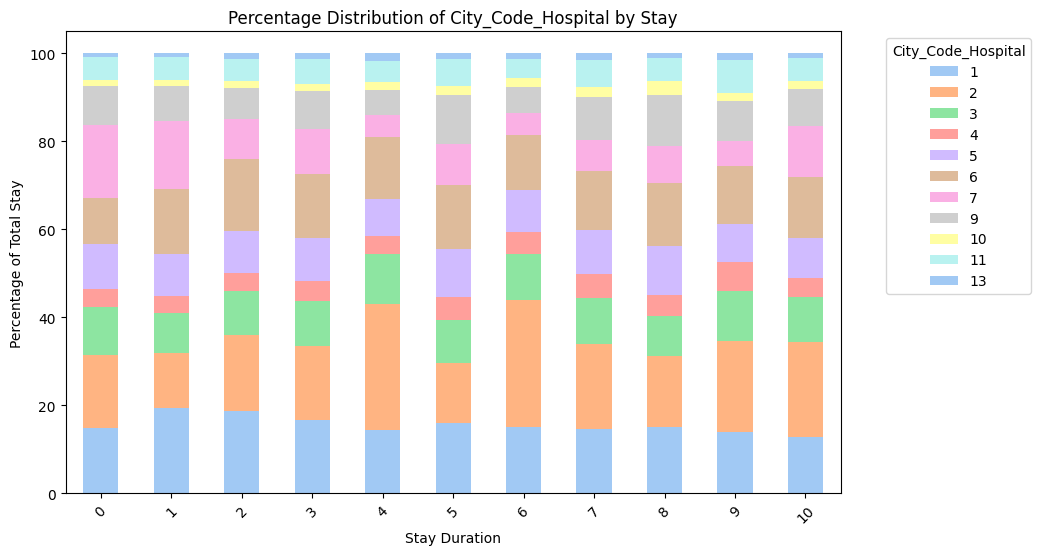

<Figure size 1000x600 with 0 Axes>

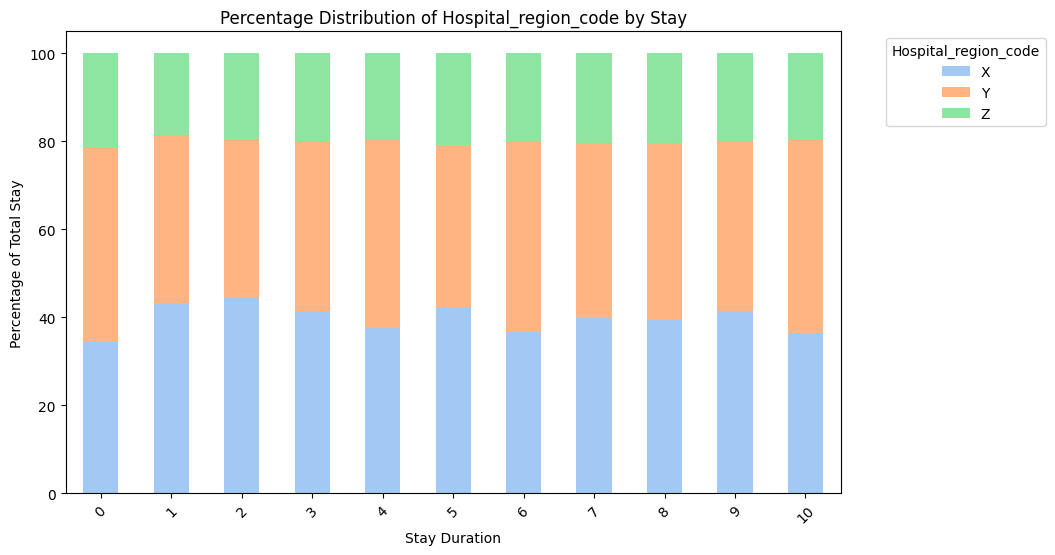

In [ ]:
plot_categorical_proportion(train_data, "Hospital_type_code")
plot_categorical_proportion(train_data, "Department")
plot_categorical_proportion(train_data, "Ward_Type")
plot_categorical_proportion(train_data, "City_Code_Hospital")
plot_categorical_proportion(train_data, "Hospital_region_code")

In [ ]:
from scipy.stats import chi2_contingency

# Select categorical columns for chi-square testing
cat_cols = train_data.select_dtypes(include=['object']).columns.tolist()

# Function to compute Cramér’s V

def cramers_v(chi2, n, min_dim):
    return np.sqrt(chi2 / (n * (min_dim - 1)))

chi_square_results = {}
cramers_v_results = {}

for col in cat_cols:
    contingency_table = pd.crosstab(train_data[col], train_data['Stay'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[col] = p  # Store p-value
    cramers_v_results[col] = cramers_v(chi2, train_data.shape[0], min(contingency_table.shape))

# Convert results to DataFrame
chi_square_df = pd.DataFrame({
    'Feature': list(chi_square_results.keys()),
    'Chi-Square P-Value': list(chi_square_results.values()),
    "Cramer's V": list(cramers_v_results.values())
}).sort_values(by="Cramer's V", ascending=False)

# Display chi-square test results
print("\nStatistical Analysis for Categorical Variables:")
print(chi_square_df)


Statistical Analysis for Categorical Variables:
                Feature  Chi-Square P-Value  Cramer's V
5             Ward_Type        0.000000e+00    0.107651
0         Hospital_code        0.000000e+00    0.075192
6    Ward_Facility_Code        0.000000e+00    0.068667
1    Hospital_type_code        0.000000e+00    0.053851
2    City_Code_Hospital        0.000000e+00    0.051597
3  Hospital_region_code       2.107242e-245    0.043706
7     City_Code_Patient        0.000000e+00    0.036820
4            Department        0.000000e+00    0.035651


## EDA Against Specific Values: Categorical

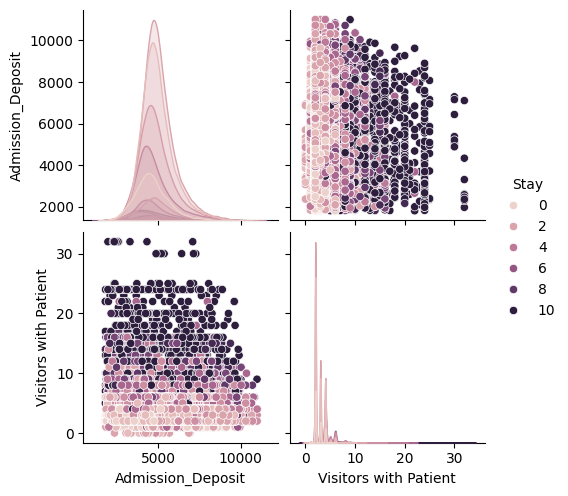

In [ ]:
# 7. Pairplot for Top Features
selected_features = ['Admission_Deposit', 'Visitors with Patient', 'Stay']
sns.pairplot(train_data[selected_features], hue='Stay', diag_kind='kde')
plt.show()

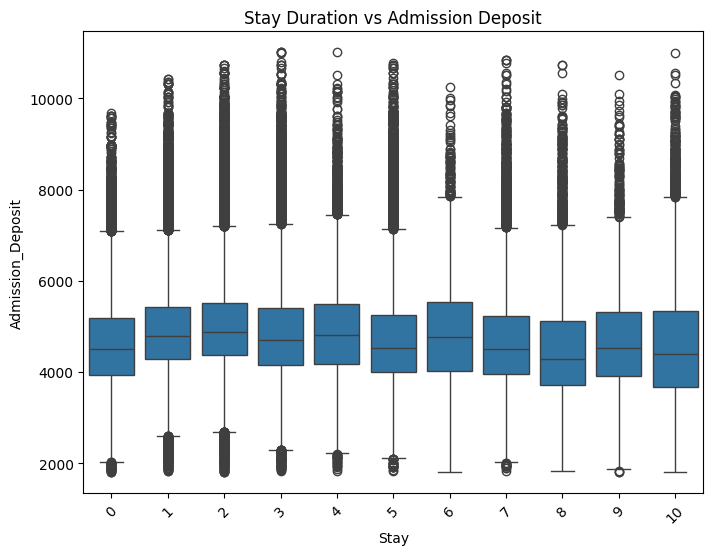

In [ ]:
# 8. Box Plot of Stay vs Admission_Deposit
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_data['Stay'], y=train_data['Admission_Deposit'])
plt.xticks(rotation=45)
plt.title('Stay Duration vs Admission Deposit')
plt.show()

### Individual severity vs. Stay percentages

Each of the following charts show the amount of severity percentage for each category for each stay period. This is to analyze does Severity type influence length of stay?

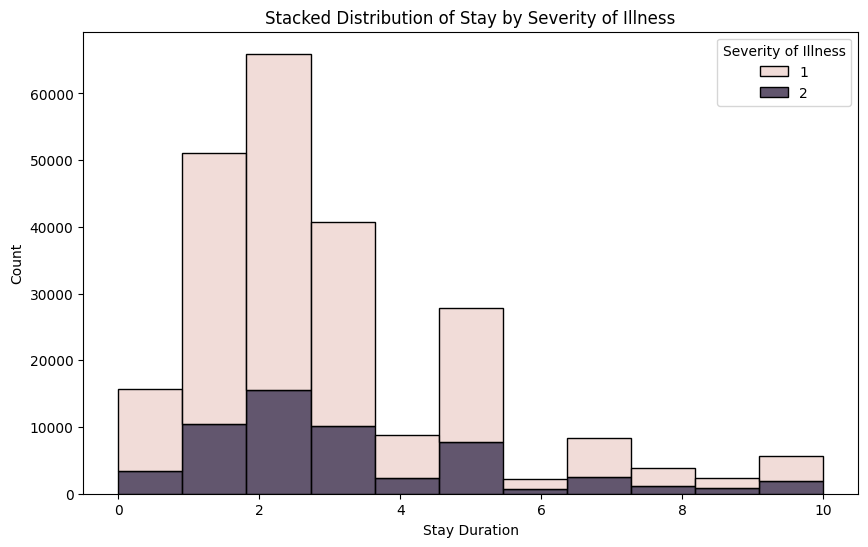

Statistical Summary for Stay by Severity of Illness:
                        count      mean       std  min  25%  50%  75%   max
Severity of Illness                                                        
1                    175843.0  2.744886  2.151571  0.0  1.0  2.0  3.0  10.0
2                     56723.0  3.131446  2.375276  0.0  2.0  2.0  5.0  10.0


In [ ]:
# Filter dataset for Severity of Illness in [1, 2, 3]
severity_data = train_data[train_data['Severity of Illness'].isin([1, 2, 3])]

# Create stacked bar chart showing distribution of Stay across Severity levels
plt.figure(figsize=(10, 6))
sns.histplot(data=severity_data, x="Stay", hue="Severity of Illness", multiple="stack", bins=11)
plt.title("Stacked Distribution of Stay by Severity of Illness")
plt.xlabel("Stay Duration")
plt.ylabel("Count")
plt.show()

# Statistical summary for each Severity level
print("Statistical Summary for Stay by Severity of Illness:")
print(severity_data.groupby('Severity of Illness')['Stay'].describe())

In [ ]:
from scipy.stats import chi2_contingency

# Select categorical columns for chi-square testing
cat_cols = train_data.select_dtypes(include=['object']).columns.tolist()

# Function to compute Cramér’s V

def cramers_v(chi2, n, min_dim):
    return np.sqrt(chi2 / (n * (min_dim - 1)))

chi_square_results = {}
cramers_v_results = {}

for col in cat_cols:
    contingency_table = pd.crosstab(train_data[col], train_data['Stay'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[col] = p  # Store p-value
    cramers_v_results[col] = cramers_v(chi2, train_data.shape[0], min(contingency_table.shape))

# Convert results to DataFrame
chi_square_df = pd.DataFrame({
    'Feature': list(chi_square_results.keys()),
    'Chi-Square P-Value': list(chi_square_results.values()),
    "Cramer's V": list(cramers_v_results.values())
}).sort_values(by="Cramer's V", ascending=False)

# Display chi-square test results
print("\nStatistical Analysis for Categorical Variables:")
print(chi_square_df)


Statistical Analysis for Categorical Variables:
                Feature  Chi-Square P-Value  Cramer's V
5             Ward_Type        0.000000e+00    0.107651
0         Hospital_code        0.000000e+00    0.075192
6    Ward_Facility_Code        0.000000e+00    0.068667
1    Hospital_type_code        0.000000e+00    0.053851
2    City_Code_Hospital        0.000000e+00    0.051597
3  Hospital_region_code       2.107242e-245    0.043706
7     City_Code_Patient        0.000000e+00    0.036820
4            Department        0.000000e+00    0.035651


<Figure size 1000x600 with 0 Axes>

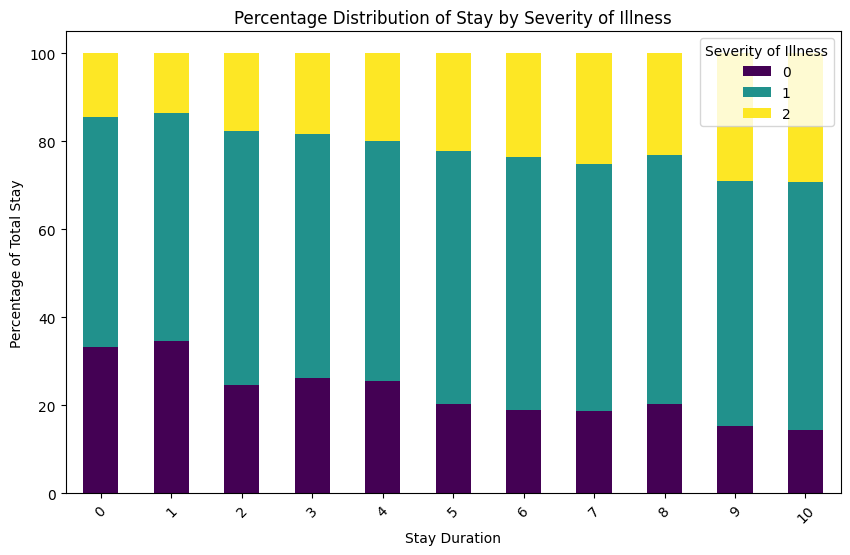

Statistical Summary for Stay by Severity of Illness:
                        count      mean       std  min  25%  50%  75%   max
Severity of Illness                                                        
Extreme               56723.0  3.131446  2.375276  0.0  2.0  2.0  5.0  10.0
Minor                 85872.0  2.317717  1.913992  0.0  1.0  2.0  3.0  10.0
Moderate             175843.0  2.744886  2.151571  0.0  1.0  2.0  3.0  10.0


In [ ]:
# Filter dataset for Severity of Illness in [1, 2, 3]
severity_data = train_data[train_data['Severity of Illness'].isin([0, 1, 2])]

# Normalize counts to percentages for each Stay duration
stay_severity_counts = severity_data.groupby("Stay")['Severity of Illness'].value_counts(normalize=True).unstack() * 100

# Rename Severity levels for better readability
severity_mapping = {0: 'Minor', 1: 'Moderate', 2: 'Extreme'}
severity_data['Severity of Illness'] = severity_data['Severity of Illness'].map(severity_mapping)

# Create stacked percentage bar chart
plt.figure(figsize=(10, 6))
stay_severity_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title("Percentage Distribution of Stay by Severity of Illness")
plt.xlabel("Stay Duration")
plt.ylabel("Percentage of Total Stay")
plt.legend(title="Severity of Illness")
plt.xticks(rotation=45)
plt.show()

# Statistical summary for each Severity level
print("Statistical Summary for Stay by Severity of Illness:")
print(severity_data.groupby('Severity of Illness')['Stay'].describe())

There is a slight decrease of length of stay among Minor admission patients and a slight increase among Extreme admission patients. We could conclude there are Minor admission patients tend to have a lower length of stay a little, and Extreme admission patients tend to have a longer length of stay a little. However, because Moderate admission is about the same throughout each level, it is harder to predict length of stay for Moderate admission patients

The following graphs show each severity level is better detail

Total rows with Severity of Minor: 85872


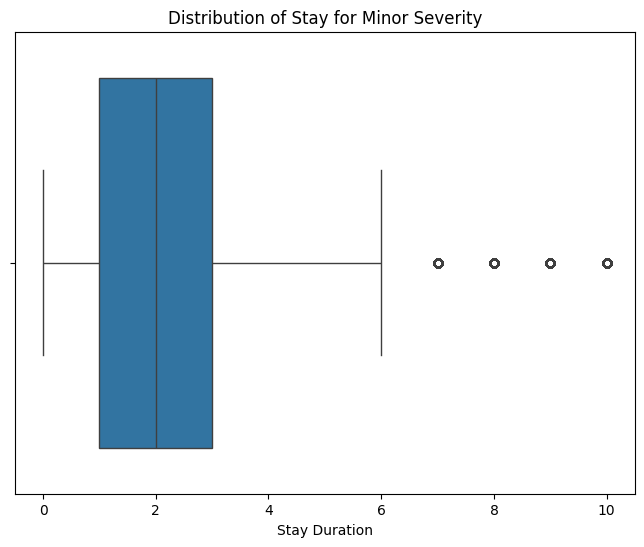

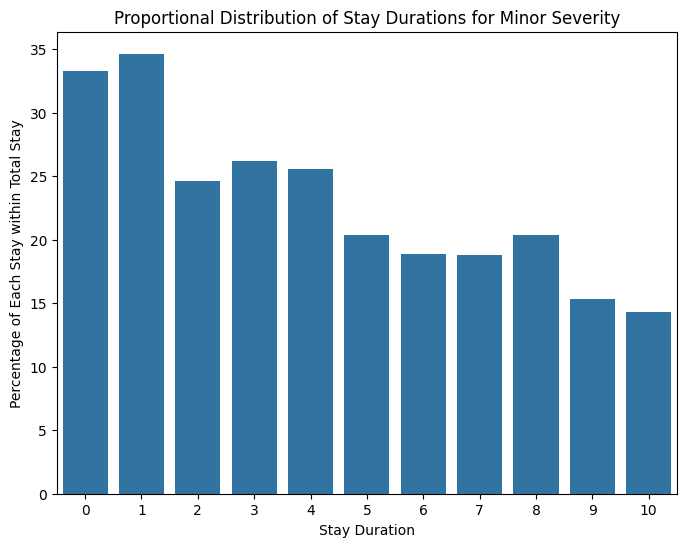

Statistical Summary for Minor vs Stay:
count    85872.000000
mean         2.317717
std          1.913992
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: Stay, dtype: float64


In [ ]:
# Extract rows where Severity of Illness is 1 (Minor)
severity_1_data = train_data[train_data['Severity of Illness'] == 0]
print("Total rows with Severity of Minor:", len(severity_1_data))

# Correctly calculate proportions for each Stay within Severity = 1
stay_counts_severity_1 = severity_1_data['Stay'].value_counts()
stay_counts_total = train_data['Stay'].value_counts()
stay_proportions = (stay_counts_severity_1 / stay_counts_total.loc[stay_counts_severity_1.index]) * 100

# Box plot of Stay for Severity 1
plt.figure(figsize=(8, 6))
sns.boxplot(x=severity_1_data['Stay'])
plt.title('Distribution of Stay for Minor Severity')
plt.xlabel('Stay Duration')
plt.show()

# Proportional Count Plot of Stay for Severity 1
plt.figure(figsize=(8, 6))
sns.barplot(x=stay_proportions.index, y=stay_proportions.values)
plt.title('Proportional Distribution of Stay Durations for Minor Severity')
plt.xlabel('Stay Duration')
plt.ylabel('Percentage of Each Stay within Total Stay')
plt.show()

# Statistical summary
print("Statistical Summary for Minor vs Stay:")
print(severity_1_data['Stay'].describe())

Severity == Minor has an overall decreasing length of stay. In other words, many minor severity patients have a low length of stay

Total rows with Severity of Moderate: 175843


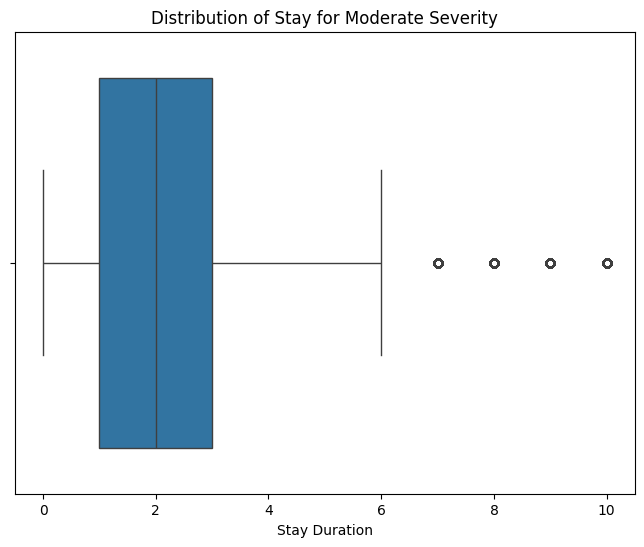

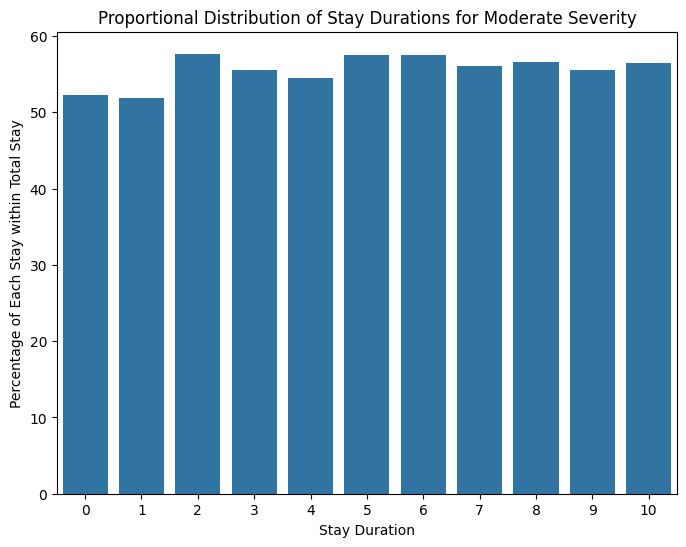

Statistical Summary for Moderate vs Stay:
count    175843.000000
mean          2.744886
std           2.151571
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          10.000000
Name: Stay, dtype: float64


In [ ]:
# Extract rows where Severity of Illness is 2 (Moderate)
severity_2_data = train_data[train_data['Severity of Illness'] == 1]
print("Total rows with Severity of Moderate:", len(severity_2_data))

# Correctly calculate proportions for each Stay within Severity = 2
stay_counts_severity_2 = severity_2_data['Stay'].value_counts()
stay_counts_total = train_data['Stay'].value_counts()
stay_proportions = (stay_counts_severity_2 / stay_counts_total.loc[stay_counts_severity_2.index]) * 100

# Box plot of Stay for Severity 2
plt.figure(figsize=(8, 6))
sns.boxplot(x=severity_2_data['Stay'])
plt.title('Distribution of Stay for Moderate Severity')
plt.xlabel('Stay Duration')
plt.show()

# Proportional Count Plot of Stay for Severity 2
plt.figure(figsize=(8, 6))
sns.barplot(x=stay_proportions.index, y=stay_proportions.values)
plt.title('Proportional Distribution of Stay Durations for Moderate Severity')
plt.xlabel('Stay Duration')
plt.ylabel('Percentage of Each Stay within Total Stay')
plt.show()

# Statistical summary
print("Statistical Summary for Moderate vs Stay:")
print(severity_2_data['Stay'].describe())

Interestingly, compared to the other two categories, this does not show a correlation between being Moderate admit vs. Stay as it is evenly distributed

Total rows with Severity of Illness = 3: 56723


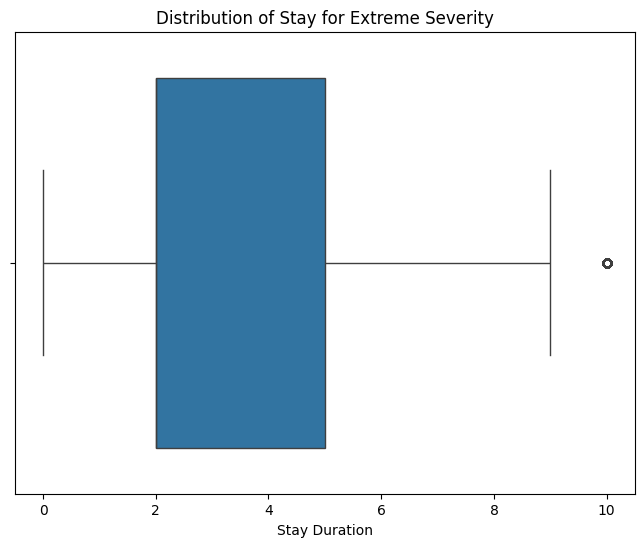

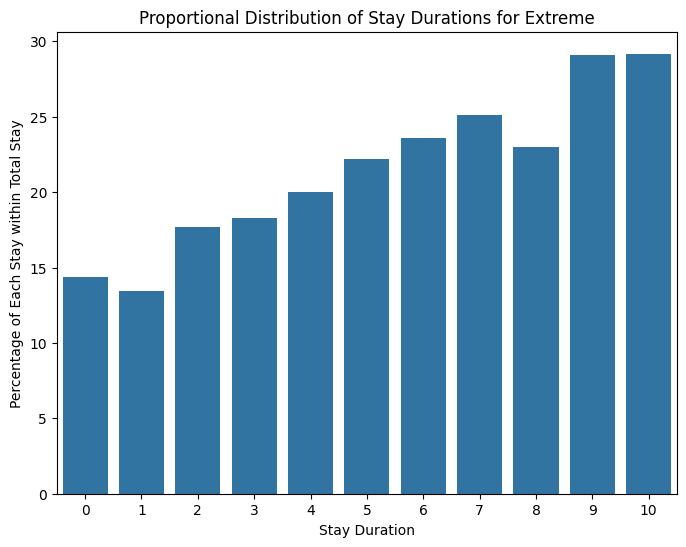

Statistical Summary for Severity Extreme vs Stay:
count    56723.000000
mean         3.131446
std          2.375276
min          0.000000
25%          2.000000
50%          2.000000
75%          5.000000
max         10.000000
Name: Stay, dtype: float64


In [ ]:
# Extract rows where Severity of Illness is 3 (Extreme)
severity_3_data = train_data[train_data['Severity of Illness'] == 2]
print("Total rows with Severity of Illness = 3:", len(severity_3_data))

# Correctly calculate proportions for each Stay within Severity = 3
stay_counts_severity_3 = severity_3_data['Stay'].value_counts()
stay_counts_total = train_data['Stay'].value_counts()
stay_proportions = (stay_counts_severity_3 / stay_counts_total.loc[stay_counts_severity_3.index]) * 100

# Box plot of Stay for Severity 3
plt.figure(figsize=(8, 6))
sns.boxplot(x=severity_3_data['Stay'])
plt.title('Distribution of Stay for Extreme Severity')
plt.xlabel('Stay Duration')
plt.show()

# Proportional Count Plot of Stay for Severity 3
plt.figure(figsize=(8, 6))
sns.barplot(x=stay_proportions.index, y=stay_proportions.values)
plt.title('Proportional Distribution of Stay Durations for Extreme')
plt.xlabel('Stay Duration')
plt.ylabel('Percentage of Each Stay within Total Stay')
plt.show()

# Statistical summary
print("Statistical Summary for Severity Extreme vs Stay:")
print(severity_3_data['Stay'].describe())


More extreme severity patients seem to have a longer stay

# Analysis Between Codes

In [ ]:
# One-hot encode categorical columns
categorical_codes = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Department', 'Ward_Facility_Code', 'Hospital_region_code', 'Ward_Type', 'City_Code_Patient', 'Stay']
train_data_encoded = pd.get_dummies(train_data, columns=categorical_codes, drop_first=False)

# Ensure all one-hot encoded categorical columns are included
encoded_cols = sorted([col for col in train_data_encoded.columns if col.startswith(tuple(categorical_codes))])

# Print all one-hot encoded column names, sorted alphabetically with new lines
print("One-hot encoded columns in train_data_encoded:")
for col in encoded_cols:
    print(col)

One-hot encoded columns in train_data_encoded:
City_Code_Hospital_1
City_Code_Hospital_10
City_Code_Hospital_11
City_Code_Hospital_13
City_Code_Hospital_2
City_Code_Hospital_3
City_Code_Hospital_4
City_Code_Hospital_5
City_Code_Hospital_6
City_Code_Hospital_7
City_Code_Hospital_9
City_Code_Patient_1
City_Code_Patient_10
City_Code_Patient_11
City_Code_Patient_12
City_Code_Patient_13
City_Code_Patient_14
City_Code_Patient_15
City_Code_Patient_16
City_Code_Patient_18
City_Code_Patient_19
City_Code_Patient_2
City_Code_Patient_20
City_Code_Patient_21
City_Code_Patient_22
City_Code_Patient_23
City_Code_Patient_24
City_Code_Patient_25
City_Code_Patient_26
City_Code_Patient_27
City_Code_Patient_28
City_Code_Patient_29
City_Code_Patient_3
City_Code_Patient_30
City_Code_Patient_31
City_Code_Patient_32
City_Code_Patient_33
City_Code_Patient_34
City_Code_Patient_35
City_Code_Patient_36
City_Code_Patient_37
City_Code_Patient_38
City_Code_Patient_4
City_Code_Patient_5
City_Code_Patient_6
City_Code_P

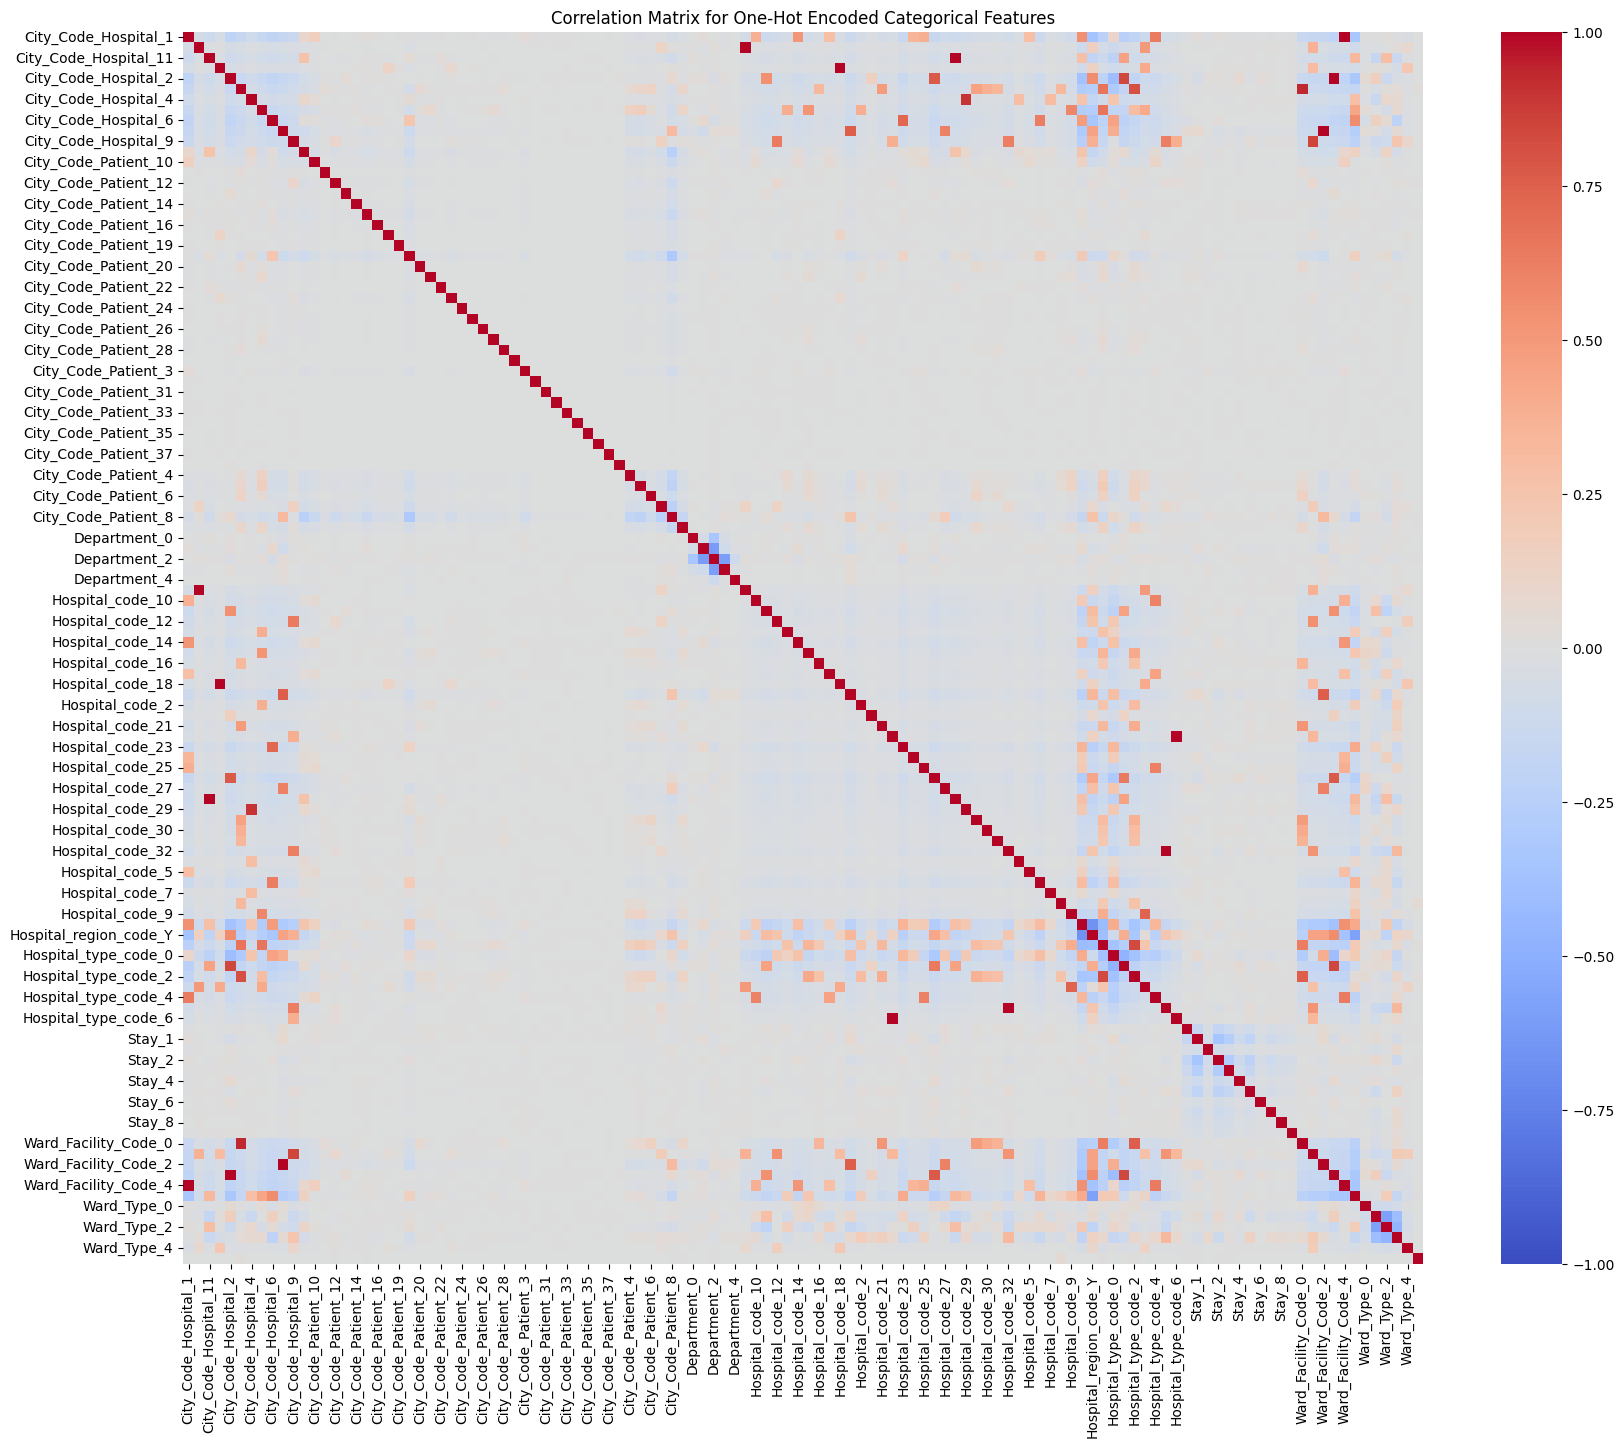

In [ ]:
# Compute correlation matrix
correlation_matrix = train_data_encoded.corr()

# Filter only the one-hot encoded categorical columns
encoded_cols = sorted([col for col in train_data_encoded.columns if any(code in col for code in categorical_codes)])
correlation_matrix= correlation_matrix.loc[encoded_cols, encoded_cols]

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix for One-Hot Encoded Categorical Features")
plt.show()

Some Hospital_code values are highly correlated with City_Code_Hospital. This suggests that certain hospitals are strongly associated with specific cities. 	Hospital_type_code and City_Code_Hospital also show strong correlations, indicating that hospital types are not uniformly distributed across cities. There are correlations between Hospital_code and Hospital_region_code, meaning that some hospitals are dominant in specific regions.

In [ ]:
correlation_threshold = 0.99  # Threshold for perfect correlation
high_correlation_pairs = correlation_matrix.stack().reset_index()
high_correlation_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_correlation_pairs = high_correlation_pairs[
    (high_correlation_pairs['Correlation'].abs() > correlation_threshold) & 
    (high_correlation_pairs['Feature 1'] != high_correlation_pairs['Feature 2'])
]
print(high_correlation_pairs)

                   Feature 1              Feature 2  Correlation
110     City_Code_Hospital_1   Ward_Facility_Code_4          1.0
171    City_Code_Hospital_10        Hospital_code_1          1.0
309    City_Code_Hospital_11       Hospital_code_28          1.0
416    City_Code_Hospital_13       Hospital_code_18          1.0
581     City_Code_Hospital_2   Ward_Facility_Code_3          1.0
1170    City_Code_Hospital_7   Ward_Facility_Code_2          1.0
6255         Hospital_code_1  City_Code_Hospital_10          1.0
7319        Hospital_code_18  City_Code_Hospital_13          1.0
8000        Hospital_code_22   Hospital_type_code_6          1.0
8616        Hospital_code_28  City_Code_Hospital_11          1.0
9297        Hospital_code_32   Hospital_type_code_5          1.0
11052   Hospital_type_code_5       Hospital_code_32          1.0
11159   Hospital_type_code_6       Hospital_code_22          1.0
12753   Ward_Facility_Code_2   City_Code_Hospital_7          1.0
12866   Ward_Facility_Cod

In [ ]:
# Filter correlations for "Stay" columns
stay_correlations = correlation_matrix.filter(like="Stay", axis=0).apply(lambda x: x[abs(x) > 0.1])

# Remove correlations between different "Stay" categories
stay_correlations = stay_correlations.drop(columns=[col for col in stay_correlations.columns if "Stay" in col], errors='ignore')

# Drop NaN values to show only relevant correlations
stay_correlations = stay_correlations.dropna(axis=1, how='all')

# Print the filtered correlations
print(stay_correlations)

         Ward_Type_1  Ward_Type_3
Stay_0           NaN          NaN
Stay_1           NaN          NaN
Stay_10          NaN          NaN
Stay_2           NaN    -0.122992
Stay_3           NaN          NaN
Stay_4           NaN          NaN
Stay_5     -0.110034     0.136599
Stay_6           NaN          NaN
Stay_7           NaN          NaN
Stay_8           NaN          NaN
Stay_9           NaN          NaN


In [ ]:
# Extract all pairs with absolute correlation > 0.4 (excluding self-correlations)
correlation_threshold = 0.4
correlation_pairs = (
    correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
correlation_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_correlation_pairs = correlation_pairs[correlation_pairs['Correlation'].abs() > correlation_threshold]

# Sort by absolute correlation value
high_correlation_pairs = high_correlation_pairs.reindex(high_correlation_pairs['Correlation'].abs().sort_values(ascending=False).index)

# Disable truncation in Pandas
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns (if needed)
pd.set_option("display.expand_frame_repr", False)  # Prevent wrapping

# Print the entire sorted DataFrame
print(high_correlation_pairs)

                   Feature 1               Feature 2  Correlation
5654        Hospital_code_22    Hospital_type_code_6     1.000000
1115    City_Code_Hospital_7    Ward_Facility_Code_2     1.000000
109     City_Code_Hospital_1    Ward_Facility_Code_4     1.000000
168    City_Code_Hospital_10         Hospital_code_1     1.000000
566     City_Code_Hospital_2    Ward_Facility_Code_3     1.000000
303    City_Code_Hospital_11        Hospital_code_28     1.000000
6137        Hospital_code_32    Hospital_type_code_5     1.000000
406    City_Code_Hospital_13        Hospital_code_18     1.000000
675     City_Code_Hospital_3    Ward_Facility_Code_0     0.934250
754     City_Code_Hospital_4        Hospital_code_29     0.899722
1221    City_Code_Hospital_9    Ward_Facility_Code_1     0.851308
546     City_Code_Hospital_2    Hospital_type_code_1     0.838538
6516    Hospital_type_code_1    Ward_Facility_Code_3     0.838538
6440  Hospital_region_code_Z    Hospital_type_code_2     0.829323
659     Ci

In [ ]:
# Count occurrences of Hospital_code_29 and City_Code_Hospital_4
hospital_28_count = train_data_encoded['Hospital_code_28'].sum()
city_hospital_11_count = train_data_encoded['City_Code_Hospital_11'].sum()

# Cross-tabulation to see how many of each exist within the other
cross_tab = pd.crosstab(train_data_encoded['Hospital_code_28'], train_data_encoded['City_Code_Hospital_11'])

# Print results
print(f"Total occurrences of Hospital_code_28: {hospital_28_count}")
print(f"Total occurrences of City_Code_Hospital_11: {city_hospital_11_count}")
print("\nCross-tabulation of Hospital_code_28 vs City_Code_Hospital_11:")
print(cross_tab)

Total occurrences of Hospital_code_28: 17137
Total occurrences of City_Code_Hospital_11: 17137

Cross-tabulation of Hospital_code_28 vs City_Code_Hospital_11:
City_Code_Hospital_11   False  True 
Hospital_code_28                    
False                  301301      0
True                        0  17137


In [ ]:
# Handle missing values by replacing with mode
if train_data['Bed Grade'].isnull().sum() > 0:
    train_data['Bed Grade'].fillna(train_data['Bed Grade'].mode()[0], inplace=True)
if train_data['City_Code_Patient'].isnull().sum() > 0:
    train_data['City_Code_Patient'].fillna(train_data['City_Code_Patient'].mode()[0], inplace=True)

/var/folders/z0/316nphkd3xsdhxgzmqc9njh00000gn/T/ipykernel_83626/711255188.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Bed Grade'].fillna(train_data['Bed Grade'].mode()[0], inplace=True)
/var/folders/z0/316nphkd3xsdhxgzmqc9njh00000gn/T/ipykernel_83626/711255188.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whi

In [ ]:
# Convert bed grade and city code patient to integers
train_data['Bed Grade'] = train_data['Bed Grade'].astype(int)
train_data['City_Code_Patient'] = train_data['City_Code_Patient'].astype(int)
train_data['Admission_Deposit'] = train_data['Admission_Deposit'].astype(int)

In [ ]:
# Categorize Stay column
stay_mapping = {
    '0-10': 0, '11-20': 1, '21-30': 2, '31-40': 3, '41-50': 4,
    '51-60': 5, '61-70': 6, '71-80': 7, '81-90': 8, '91-100': 9,
    '100 Days': 9, 'More than 100 Days': 10
}
train_data['Stay'] = train_data['Stay'].map(stay_mapping)

In [ ]:
# Categorize Age column
age_mapping = {
    '0-10': 0, '11-20': 1, '21-30': 2, '31-40': 3, '41-50': 4,
    '51-60': 5, '61-70': 6, '71-80': 7, '81-90': 8, '91-100': 9,
}
train_data['Age'] = train_data['Age'].map(stay_mapping)

In [ ]:
label_encoders = {}

# Label Encode Department
if 'Department' in train_data.columns:
    le = LabelEncoder()
    train_data['Department'] = le.fit_transform(train_data['Department'])
    label_encoders['Department'] = le


In [ ]:
# Convert categorical variables of codes and phrases to numbers
if 'Hospital_type_code' in train_data.columns:
    train_data['Hospital_type_code'] = train_data['Hospital_type_code'].map(lambda x: ord(x.lower()) - ord('a'))
if 'Ward_Facility_Code' in train_data.columns:
    train_data['Ward_Facility_Code'] = train_data['Ward_Facility_Code'].map(lambda x: ord(x) - ord('A'))
if 'Hospital_region_code' in train_data.columns:
    region_mapping = {'X': 0, 'Y': 1, 'Z': 2}
if 'Ward_Type' in train_data.columns:
    train_data['Ward_Type'] = train_data['Ward_Type'].map(lambda x: ord(x) - ord('P'))
if 'Type of Admission' in train_data.columns:
    admission_mapping = {'Trauma': 0, 'Urgent': 1, 'Emergency': 2}
    train_data['Type of Admission'] = train_data['Type of Admission'].map(admission_mapping)
if 'Severity of Illness' in train_data.columns:
    severity_mapping = {'Minor': 0, 'Moderate': 1, 'Extreme': 2}
    train_data['Severity of Illness'] = train_data['Severity of Illness'].map(severity_mapping)